# Trabajo Práctico 1 : Reservas de Hotel


## Librerias


Importamos las librerias que vamos a necesitar en el transcurso del trabajo.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sc
import scipy.stats as st
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, precision_recall_curve, roc_curve
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, f1_score, accuracy_score , roc_auc_score, recall_score, precision_score
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image
import pydotplus
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, classification_report
random.seed(33)

pd.set_option('display.max_columns', 200)

In [3]:
def mostrar_scores(y_test, y_prediccion):
    accuracy = accuracy_score(y_test,y_prediccion)
    recall = recall_score(y_test,y_prediccion)
    f1 = f1_score(y_test,y_prediccion,)
    precision = precision_score(y_test,y_prediccion)

    print("Accuracy: "+str(accuracy))
    print("Recall: "+str(recall))
    print("Precision: "+str(precision))
    print("f1 score: "+str(f1))

## Ensambles


A continuacion vamos a probar los distintos ensambles pedidos en el trabajo y ver como se comportan con nuestro dataset. Por cada ensamble se submitteara como minimo un csv a kaggle para ver que tan bien generaliza nuestro modelo.


In [120]:
df_ensambles = pd.read_csv('dataframe_chp1.csv')

### KNN


Como es un modelo simple que no va a dar grandes resultados como los demas, crearemos un modelo con los mejores hiperparametros encontrados en la busqueda de los mismos. Tambien, comenzaremos con todas las features del dataset para ver como rinde y, luego, iremos sacando features para ver si podemos mejorar el modelo.


In [60]:
df_a_utilizar = df_ensambles.copy()

In [6]:
agentes = df_a_utilizar[['agent_id']].value_counts().reset_index()

agentes.columns = ['agent_id', 'cantidad']
agentes_mayoritarios = agentes[agentes['cantidad'] > 20]
agentes_minoritarios = agentes[agentes['cantidad'] <= 20]

df_agentes_mayoritarios = df_a_utilizar[df_a_utilizar['agent_id'].isin(agentes_mayoritarios['agent_id'])]
df_agentes_minoritarios = df_a_utilizar[df_a_utilizar['agent_id'].isin(agentes_minoritarios['agent_id'])]
df_agentes_minoritarios.loc[df_a_utilizar['agent_id'].isin(agentes_minoritarios['agent_id']),'agent_id'] = 'Otros'

df_agentes = pd.concat([df_agentes_mayoritarios, df_agentes_minoritarios])

paises = df_agentes[['country']].value_counts().reset_index()
paises.columns = ['country', 'cantidad']
paises_mayoritarios = paises[paises['cantidad'] > 15]
paises_minoritarios = paises[paises['cantidad'] <= 15]

df_paises_mayoritarios = df_agentes[df_agentes['country'].isin(paises_mayoritarios['country'])]
df_paises_minoritarios = df_agentes[df_agentes['country'].isin(paises_minoritarios['country'])]
df_paises_minoritarios.loc[df_agentes['country'].isin(paises_minoritarios['country']),'country'] = 'Otros'

df_encode = pd.concat([df_paises_mayoritarios, df_paises_minoritarios])

In [7]:
columns = [
       'hotel',
    'lead_time',
    'year',
    # 'month',
    'week_number',
    # 'day_of_month',
    # 'stays_in_weekend_nights',
    # 'stays_in_week_nights',
    # 'adults',
    # 'children',
    # 'babies',
    'meal_type',
    'country',
    'market_segment',
    # 'distribution_channel',
    'is_repeated_guest',
    'previous_cancellations',
    # 'previous_bookings_not_canceled',
    'booking_changes',
    'deposit_type',
    'agent_id',
    'days_in_waiting_list',
    'customer_type',
    'average_daily_rate',
    'required_car_parking_spaces',
    'total_of_special_requests',
    'is_canceled',
    # 'total_nights',
    'total_people'
]

filtrado = df_encode[columns]

dummy_columns = [
    'hotel',
    'deposit_type',
    'market_segment',
    'agent_id',
    'country',
    'customer_type',
    'meal_type',
    # 'distribution_channel',
    # 'month',
    # 'year'
]

df_con_dummies = pd.get_dummies(
    filtrado, columns=dummy_columns, drop_first=True)

df_con_dummies['cuarto_correcto'] = df_encode['reserved_room_type'] == df_encode['assigned_room_type']
df_con_dummies['cuarto_correcto'] = df_con_dummies['cuarto_correcto'].apply(lambda x: 1 if x == True else 0)

df_trabajo_x = df_con_dummies.drop(
    ['is_canceled'], axis='columns', inplace=False)
df_trabajo_y = df_con_dummies['is_canceled'].copy()
df_trabajo_y.columns = ['is_canceled']

target = 'is_canceled'
x_train, x_test, y_train, y_test = train_test_split(df_trabajo_x,
                                                    df_trabajo_y,
                                                    test_size=0.3,
                                                    random_state=11457,
                                                    stratify=df_con_dummies[target].values
                                                    )

Primero observamos los distintos parametros que puede llevar nuestro modelo.


In [8]:
from sklearn.neighbors import KNeighborsClassifier
clasificador_KNN = KNeighborsClassifier()
clasificador_KNN.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

Con esto vamos a darnos una idea de qué cantidad de folds debe utilizar nuestro clasificador. Como nuestro dataset es muy amplio vamos a probar con distintos valores de n, desde 3 a 14, para ver cual es el que mejor se ajusta a nuestro modelo.


In [21]:
cantidad_de_folds = range(3, 15)
metricas = []

for n in cantidad_de_folds:
    clasificador_KNN = KNeighborsClassifier()
    scores = cross_val_score(
        clasificador_KNN, x_train.values, y_train, cv=n, scoring='f1')
    metricas.append(scores.mean())
    print("cantidad de folds = "+str(n) +
          " -> media f1-score:"+str(scores.mean()))

cantidad de folds = 3 -> media f1-score:0.7121281469266515
cantidad de folds = 4 -> media f1-score:0.717059356586887
cantidad de folds = 5 -> media f1-score:0.7212615210538589
cantidad de folds = 6 -> media f1-score:0.7207706477371209
cantidad de folds = 7 -> media f1-score:0.7231132626905014
cantidad de folds = 8 -> media f1-score:0.7229658463643833
cantidad de folds = 9 -> media f1-score:0.7244280702648468
cantidad de folds = 10 -> media f1-score:0.723228499554757
cantidad de folds = 11 -> media f1-score:0.7245971780093835
cantidad de folds = 12 -> media f1-score:0.7242499686042465
cantidad de folds = 13 -> media f1-score:0.7261831537715201
cantidad de folds = 14 -> media f1-score:0.7261715706797108


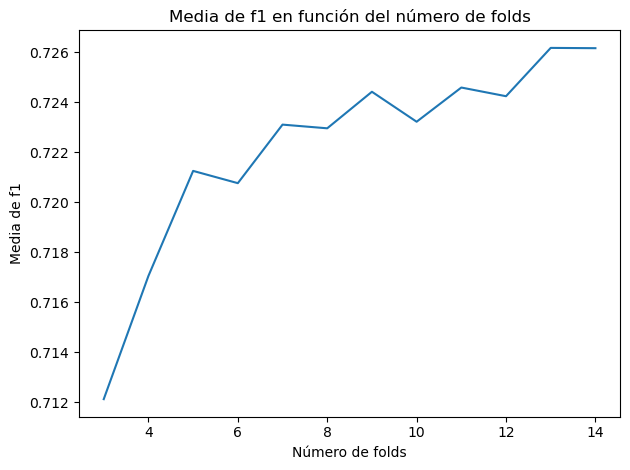

In [22]:
sns.lineplot(x=cantidad_de_folds, y=metricas)
plt.xlabel("Número de folds")
plt.ylabel("Media de f1")
plt.title("Media de f1 en función del número de folds")
plt.tight_layout()
plt.show()

In [33]:
mejor_score_folds = max(metricas)
indice_mejor_cantidad_folds = metricas.index(mejor_score_folds)
print(
    f"La media maxima es con {indice_mejor_cantidad_folds + 3} folds y su score es de {mejor_score_folds}")

NameError: name 'metricas' is not defined

Podemos utilizar esta información para ajustar mejor nuestra búsqueda de hiperparámetros. Si bien 13 folds es el que mejor se ajusta, vamos a probar la búsqueda de hiperparámetros con 7 folds nada mas, ya que, con una cantidad elevada de folds nuestro algoritmo de búsqueda es muy lento.


In [9]:
grilla_parametros = {'n_neighbors': range(3, 15),
                     'weights': ['distance', 'uniform'],
                     'algorithm': ['ball_tree', 'kd_tree'],
                     'metric': ['euclidean', 'manhattan', 'chebyshev']
                     }

iteraciones = 50

knn_hiperparams = RandomizedSearchCV(estimator=KNeighborsClassifier(),
                                        param_distributions=grilla_parametros,
                                        scoring=make_scorer(f1_score),
                                        cv=StratifiedKFold(n_splits=7),
                                        n_iter=iteraciones, n_jobs=-1, random_state=33)
                                        

knn_hiperparams.fit(x_train.values, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=7, random_state=None, shuffle=False),
                   estimator=KNeighborsClassifier(), n_iter=50, n_jobs=-1,
                   param_distributions={'algorithm': ['ball_tree', 'kd_tree'],
                                        'metric': ['euclidean', 'manhattan',
                                                   'chebyshev'],
                                        'n_neighbors': range(3, 15),
                                        'weights': ['distance', 'uniform']},
                   random_state=33, scoring=make_scorer(f1_score))

In [12]:
print(knn_hiperparams.cv_results_['mean_test_score'])
print(knn_hiperparams.best_params_)
print(knn_hiperparams.best_score_)

[0.70529706 0.70545427 0.73570698 0.73373048 0.7482327  0.69061434
 0.77186705 0.74003556 0.78327218 0.75714044 0.73316749 0.73468378
 0.7469195  0.74683815 0.7739494  0.73246713 0.73279507 0.71625707
 0.69884431 0.74698642 0.73716866 0.68838419 0.67293193 0.73327429
 0.73663302 0.78371648 0.73410985 0.77955293 0.67238417 0.6951684
 0.72999979 0.782271   0.68396182 0.69046036 0.78071314 0.73227063
 0.74796509 0.68654906 0.74832206 0.74935939 0.730519   0.69507978
 0.67407334 0.7393332  0.69891133 0.73413581 0.75656881 0.72141697
 0.75010061 0.7398416 ]
{'weights': 'distance', 'n_neighbors': 12, 'metric': 'manhattan', 'algorithm': 'kd_tree'}
0.783716476398599


Con esto podemos observar los mejores hiperparametros que encontró la búsqueda. Ahora vamos a predictear usando nuestro modelo con estos hiperparametros y ver que resultados obtenemos.

In [ ]:
y_pred = knn_hiperparams.predict(x_test.values)

In [69]:
mostrar_scores(y_test, y_pred)

Accuracy: 0.7707696915244086
Recall: 0.8152002904514098
Precision: 0.7454625940681717
f1 score: 0.778773339499393


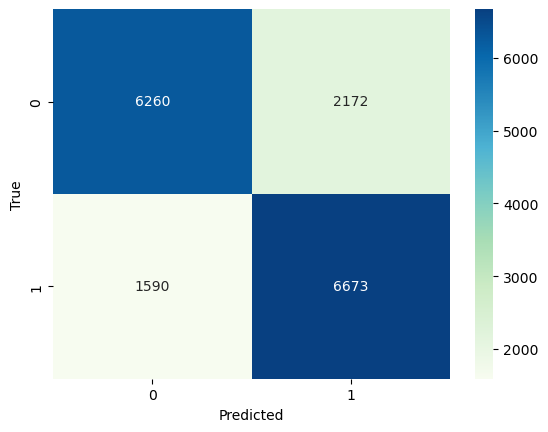

In [ ]:
tabla = confusion_matrix(y_test, y_pred)
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Como podemos observar, los hiperparametros mejoraron considerablemente el f1 score, sin embargo no es un valor muy alto. Vamos a probar con otros modelos para ver si podemos mejorar este valor.

A continuacion, vamos a ver como se comporta nuestro modelo con los datos de train para analizar si hubo overfitting o no.


In [ ]:
y_predict_train = knn_hiperparams.predict(x_train.values)
mostrar_scores(y_train, y_predict_train)

Accuracy: 0.9959440379925555
Recall: 0.9946576763485477
Precision: 0.9971401830282862
f1 score: 0.9958973826339843


Claramente hubo overfitting, debido a que la cantidad de vecinos más cercanos es muy baja, y por lo tanto, el modelo se ajusta muy bien a los datos de entrenamiento. Podria argumentarse que es por un valor de k muy bajo, sin embargo según investigaciones nuestras, un buen valor de k sería la raíz cuadrada del total de samples que tiene nuestro dataset dividido dos. Además, cabe recalcar que tanto la cantidad de clases como la cantidad de caracteristicas de nuestro dataset no deberían tener un rol importante a la hora de determinar nuestro k.


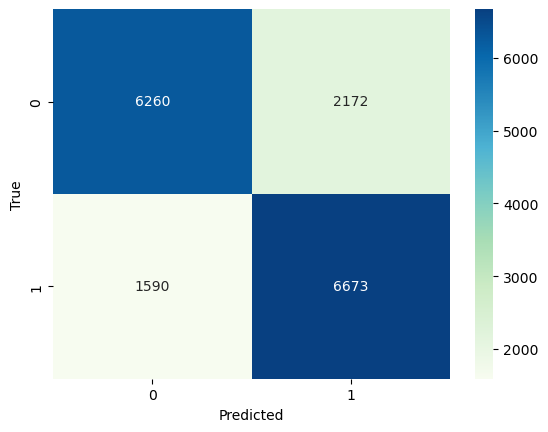

In [ ]:
tabla = confusion_matrix(y_test, y_pred)
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### SVM


Para continuar, vamos a crear un modelo de support vector machine para ver que tan bien puede predecir nuestra variable target.


In [10]:
df_a_utilizar = df_ensambles.copy()

In [13]:
agentes = df_a_utilizar[['agent_id']].value_counts().reset_index()

agentes.columns = ['agent_id', 'cantidad']
agentes_mayoritarios = agentes[agentes['cantidad'] > 20]
agentes_minoritarios = agentes[agentes['cantidad'] <= 20]

df_agentes_mayoritarios = df_a_utilizar[df_a_utilizar['agent_id'].isin(agentes_mayoritarios['agent_id'])]
df_agentes_minoritarios = df_a_utilizar[df_a_utilizar['agent_id'].isin(agentes_minoritarios['agent_id'])]
df_agentes_minoritarios.loc[df_a_utilizar['agent_id'].isin(agentes_minoritarios['agent_id']),'agent_id'] = 'Otros'

df_agentes = pd.concat([df_agentes_mayoritarios, df_agentes_minoritarios])

paises = df_agentes[['country']].value_counts().reset_index()
paises.columns = ['country', 'cantidad']
paises_mayoritarios = paises[paises['cantidad'] > 15]
paises_minoritarios = paises[paises['cantidad'] <= 15]

df_paises_mayoritarios = df_agentes[df_agentes['country'].isin(paises_mayoritarios['country'])]
df_paises_minoritarios = df_agentes[df_agentes['country'].isin(paises_minoritarios['country'])]
df_paises_minoritarios.loc[df_agentes['country'].isin(paises_minoritarios['country']),'country'] = 'Otros'

df_encode = pd.concat([df_paises_mayoritarios, df_paises_minoritarios])

In [14]:


columns = [
       'hotel',
    'lead_time',
    'year',
    # 'month',
    'week_number',
    # 'day_of_month',
    # 'stays_in_weekend_nights',
    # 'stays_in_week_nights',
    # 'adults',
    # 'children',
    # 'babies',
    'meal_type',
    'country',
    'market_segment',
    # 'distribution_channel',
    'is_repeated_guest',
    'previous_cancellations',
    # 'previous_bookings_not_canceled',
    'booking_changes',
    'deposit_type',
    'agent_id',
    'days_in_waiting_list',
    'customer_type',
    'average_daily_rate',
    'required_car_parking_spaces',
    'total_of_special_requests',
    'is_canceled',
    # 'total_nights',
    'total_people'
]

filtrado = df_encode[columns]

dummy_columns = [
    'hotel',
    'deposit_type',
    'market_segment',
    'agent_id',
    'country',
    'customer_type',
    'meal_type',
    # 'distribution_channel',
    # 'month',
    # 'year'
]

df_con_dummies = pd.get_dummies(
    filtrado, columns=dummy_columns, drop_first=True)

df_con_dummies['cuarto_correcto'] = df_encode['reserved_room_type'] == df_encode['assigned_room_type']
df_con_dummies['cuarto_correcto'] = df_con_dummies['cuarto_correcto'].apply(lambda x: 1 if x == True else 0)

df_trabajo_x = df_con_dummies.drop(['is_canceled'], axis='columns', inplace=False)
df_trabajo_y = df_con_dummies['is_canceled'].copy()


x_train, x_test, y_train, y_test = train_test_split(df_trabajo_x,
                                                    df_trabajo_y,
                                                    test_size=0.2,
                                                    random_state=11457,
                                                    stratify=df_con_dummies['is_canceled'].values
                                                    )

In [40]:
svm = SVC()

svm.fit(x_train, y_train)

y_pred = svm.predict(x_test)
mostrar_scores(y_pred, y_test)

Como podemos ver el f1 score es muy bajo, esto puede ser debido a que as variables no estan normalizadas, vamos a intentar con un min-max sclaer y con una normalizacion gaussiana para ver cual obtiene mejores resultados

In [15]:
min_max = preprocessing.MinMaxScaler()
x_train_minmax = min_max.fit_transform(x_train)
x_test_minmax = min_max.transform(x_test)

normal = preprocessing.StandardScaler()
x_train_normal = normal.fit_transform(x_train)
x_test_normal = normal.transform(x_test)

In [11]:
svm_minmax = SVC(random_state=33)

svm_minmax.fit(x_train_minmax, y_train)

y_pred = svm_minmax.predict(x_test_minmax)
mostrar_scores(y_pred, y_test)

[LibSVM].............*...*
optimization finished, #iter = 16575
obj = -14904.760465, rho = -0.863642
nSV = 16751, nBSV = 15524
Total nSV = 16751
Accuracy: 0.854177897574124
Recall: 0.8355785837651123
Precision: 0.8781993102196406
f1 score: 0.8563589698203382


Al usar una normalizacion por minimos y maximos el f1 score mejoro considerablemente, a continuacion vamos a probar con una normalizacion mediante una distribucion normal

In [ ]:
svm_normal = SVC(random_state=33)

svm_normal.fit(x_train_normal, y_train)

y_pred = svm_normal.predict(x_test_normal)
mostrar_scores(y_pred, y_test)

Accuracy: 0.8341419586702605
Recall: 0.8337889557135046
Precision: 0.8304592485024506
f1 score: 0.8321207711895235


Como podemos ver, la normalizacion por minimos y maximos fue considerablemente mejor, es por eso que nos vamos a quedar con el escalado de los datos mediante minimos y maximos.

Ahora vamos a intentar variar el kernel y parametros para ver si podemos mejorar el scoring.

##### Kernel Polinomial

In [73]:
svm_poly = SVC(kernel='poly', random_state=33)

svm_poly.fit(x_train_minmax, y_train)

y_pred = svm_poly.predict(x_test_minmax)
mostrar_scores(y_pred, y_test)

Accuracy: 0.8499550763701708
Recall: 0.8337680403408103
Precision: 0.8703939008894537
f1 score: 0.8516873889875667


In [ ]:
svm_poly_cuadratica = SVC(kernel='poly', degree=2, random_state=33)

svm_poly_cuadratica.fit(x_train_minmax, y_train)

y_pred = svm_poly_cuadratica.predict(x_test_minmax)
mostrar_scores(y_pred, y_test)

In [16]:
svm_poly_5 = SVC(kernel='poly', degree=5, random_state=33)

svm_poly_5.fit(x_train_minmax, y_train)

y_pred = svm_poly_5.predict(x_test_minmax)
mostrar_scores(y_pred, y_test)

Accuracy: 0.8532794249775382
Recall: 0.8366921473245309
Precision: 0.8742058449809402
f1 score: 0.8550377274744784


In [27]:
svm_poly_5_gamma = SVC(kernel='poly', degree=5, gamma='auto', random_state=33)

svm_poly_5_gamma.fit(x_train_minmax, y_train)

y_pred = svm_poly_5_gamma.predict(x_test_minmax)
mostrar_scores(y_pred, y_test)

Accuracy: 0.5050314465408805
Recall: 0.0
Precision: 0.0
f1 score: 0.0


/Users/juampi/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### Kernel Sigmoide

In [24]:
svm_sigmoide = SVC(kernel='sigmoid')

svm_sigmoide.fit(x_train_minmax, y_train)

y_pred = svm_sigmoide.predict(x_test_minmax)
mostrar_scores(y_pred, y_test)

Accuracy: 0.667654986522911
Recall: 0.6667280766396463
Precision: 0.6569250317662008
f1 score: 0.6617902532687209


In [25]:
svm_sigmoide_gamma = SVC(kernel='sigmoid', gamma='auto')

svm_sigmoide_gamma.fit(x_train_minmax, y_train)

y_pred = svm_sigmoide_gamma.predict(x_test_minmax)
mostrar_scores(y_pred, y_test)

Accuracy: 0.8166217430368373
Recall: 0.8054968287526427
Precision: 0.8299146850608096
f1 score: 0.8175234689316049


##### Kernel Lineal

In [26]:
svm_lin = SVC(kernel='linear', random_state=33)

svm_lin.fit(x_train_minmax, y_train)
y_pred = svm_lin.predict(x_test_minmax)
mostrar_scores(y_pred, y_test)

Accuracy: 0.8265049415992812
Recall: 0.8161894662424886
Precision: 0.8382646578326375
f1 score: 0.8270797886630249


Como podemos ver, luego de intentar varios kernels con varios parametros diferentes, el modelo que mejor resulto para predecir nuestra variable target fue el kernel polinomial con grado 3 (default). Por lo tanto vamos a utilizar ese modelo para los ensambles hibridos mas tarde.

### RandomForest


In [23]:
df_a_utilizar = df_ensambles.copy()

#### RandomForest Basico


Utilizamos todas las features del dataset para entrenar el modelo. Luego, vamos a ir variando las features para ver si mejora o empeora nuestro clasificador.


In [24]:
columns = [
    'hotel',
    'lead_time',
    'year',
    'month',
    'week_number',
    'day_of_month',
    'stays_in_weekend_nights',
    'stays_in_week_nights',
    'adults',
    'children',
    'babies',
    'meal_type',
    'country',
    'market_segment',
    'distribution_channel',
    'is_repeated_guest',
    'previous_cancellations',
    'previous_bookings_not_canceled',
    'reserved_room_type',
    'assigned_room_type',
    'booking_changes',
    'deposit_type',
    'agent_id',
    'days_in_waiting_list',
    'customer_type',
    'average_daily_rate',
    'required_car_parking_spaces',
    'total_of_special_requests',
    'is_canceled',
    'total_nights',
    'total_people'
]

filtrado = df_a_utilizar[columns]

dummy_columns = ['hotel', 'deposit_type', 'market_segment', 'agent_id', 'country', 'customer_type',
                 'meal_type', 'reserved_room_type', 'assigned_room_type', 'distribution_channel', 'month', 'year']
df_con_dummies = pd.get_dummies(filtrado, columns=dummy_columns, drop_first=True)

df_trabajo_x = df_con_dummies.drop(['is_canceled'], axis='columns', inplace=False)
df_trabajo_y = df_con_dummies['is_canceled'].copy()


x_train, x_test, y_train, y_test = train_test_split(df_trabajo_x,
                                                    df_trabajo_y,
                                                    test_size=0.3,
                                                    random_state=11457,
                                                    stratify=df_con_dummies[target].values
                                                    )

Primero, vamos a probar con un random forest con pocos parametros. Luego, vamos a realizar una busqueda de hiperparametros para ver si podemos mejorar el modelo.


In [96]:
random_forest_basico = RandomForestClassifier(max_depth=20, random_state=33, n_estimators=200, n_jobs=-1)
random_forest_basico.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 33,
 'verbose': 0,
 'warm_start': False}

In [97]:
modelo = random_forest_basico.fit(X=x_train, y=y_train)
y_pred = modelo.predict(x_test)
mostrar_scores(y_test, y_pred)

Accuracy: 0.8722371967654986
Recall: 0.8780104078421881
Precision: 0.8657517899761337
f1 score: 0.8718380099741634


Ya de por si el random forest nos dio un resultado relativamente alto comparado a los otros modelos de ensambles, vamos a ver si podemos mejorar este puntaje con hiperparametros y seleccionando variables

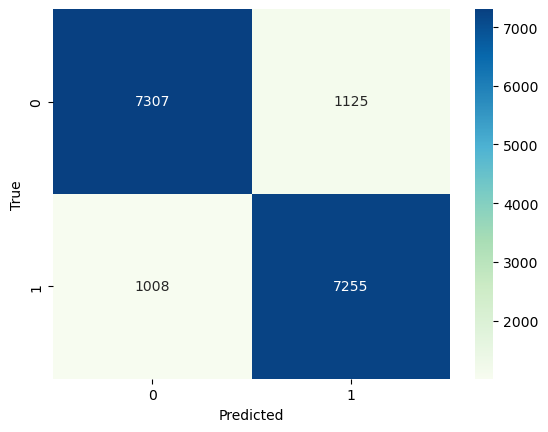

In [98]:
tabla = confusion_matrix(y_test, y_pred)
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [99]:
y_predict_train = modelo.predict(x_train)
mostrar_scores(y_train, y_predict_train)

Accuracy: 0.9112309074573226
Recall: 0.9228215767634855
Precision: 0.9003137334277908
f1 score: 0.9114287177910968


Hay un leve overfit pero esto no deberia preocuparnos en este momento, ya que este es el modelo de RandomForest mas basico que vamos a utilizar. A continuacion vamos a probar con un modelo mas complejo para ver si podemos mejorar el puntaje.

#### RandomForest Mejorado


Vamos a filtrar variables de manera que nuestro modelo de ensamble RandomForest mejore su predicción.

In [113]:
columns = [
    'hotel',
    'lead_time',
    'year',
    # 'month',
    'week_number',
    # 'day_of_month',
    # 'stays_in_weekend_nights',
    # 'stays_in_week_nights',
    # 'adults',
    # 'children',
    # 'babies',
    'meal_type',
    'country',
    'market_segment',
    # 'distribution_channel',
    'is_repeated_guest',
    'previous_cancellations',
    # 'previous_bookings_not_canceled',
    'booking_changes',
    'deposit_type',
    'agent_id',
    'days_in_waiting_list',
    'customer_type',
    'average_daily_rate',
    'required_car_parking_spaces',
    'total_of_special_requests',
    'is_canceled',
    # 'total_nights',
    'total_people'
]

dummy_columns = [
    'hotel',
    'deposit_type',
    'market_segment',
    'agent_id',
    'country',
    'customer_type',
    'meal_type',
    # 'distribution_channel',
    # 'month',
    # 'year'
]

Vamos a realizar un filtrado tal como hicimos antes con los arboles de decisión ya que, como las variables agent_id y country pueden tomar demasiados valores distintos, existe la posibilidad de que el modelo tenga un nodo de decision con un valor que no existe en el dataset de test o viceversa.


In [128]:
agentes = df_a_utilizar[['agent_id']].value_counts().reset_index()

agentes.columns = ['agent_id', 'cantidad']
agentes_mayoritarios = agentes[agentes['cantidad'] > 20]
agentes_minoritarios = agentes[agentes['cantidad'] <= 20]

df_agentes_mayoritarios = df_a_utilizar[df_a_utilizar['agent_id'].isin(agentes_mayoritarios['agent_id'])]
df_agentes_minoritarios = df_a_utilizar[df_a_utilizar['agent_id'].isin(agentes_minoritarios['agent_id'])]
df_agentes_minoritarios.loc[df_a_utilizar['agent_id'].isin(agentes_minoritarios['agent_id']), 'agent_id'] = 'Otros'

df_agentes = pd.concat([df_agentes_mayoritarios, df_agentes_minoritarios])

paises = df_agentes[['country']].value_counts().reset_index()
paises.columns = ['country', 'cantidad']
paises_mayoritarios = paises[paises['cantidad'] > 15]
paises_minoritarios = paises[paises['cantidad'] <= 15]

df_paises_mayoritarios = df_agentes[df_agentes['country'].isin(paises_mayoritarios['country'])]
df_paises_minoritarios = df_agentes[df_agentes['country'].isin(paises_minoritarios['country'])]
df_paises_minoritarios.loc[df_agentes['country'].isin(paises_minoritarios['country']), 'country'] = 'Otros'

df_encode = pd.concat([df_paises_mayoritarios, df_paises_minoritarios])

filtrado = df_encode[columns]

df_con_dummies = pd.get_dummies(filtrado, columns=dummy_columns, drop_first=True)


df_con_dummies['cuarto_correcto'] = df_ensambles['reserved_room_type'] == df_ensambles['assigned_room_type']
df_con_dummies['cuarto_correcto'] = df_con_dummies['cuarto_correcto'].apply(
    lambda x: 1 if x == True else 0)

df_trabajo_x = df_con_dummies.drop(
    ['is_canceled'], axis='columns', inplace=False)
df_trabajo_y = df_con_dummies['is_canceled'].copy()

In [129]:
x_train, x_test, y_train, y_test = train_test_split(df_trabajo_x,
                                                    df_trabajo_y,
                                                    test_size=0.3,
                                                    random_state=11457,
                                                    stratify=df_con_dummies[target].values
                                                    )

In [161]:
random_forest_mejorado = RandomForestClassifier(criterion='entropy',
                                                max_depth=25,
                                                min_samples_leaf=1,
                                                n_estimators=100,
                                                random_state=13,
                                                n_jobs=-1,
                                                max_features='sqrt',
                                                class_weight='balanced_subsample',
                                                )
random_forest_mejorado.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced_subsample',
 'criterion': 'entropy',
 'max_depth': 25,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 13,
 'verbose': 0,
 'warm_start': False}

Usamos un escalador ya que no afecta nuestro arbol, pero si afecta a los ensambles hibridos que vamos a realizar mas adelante. Esto se debe a que los ensambles hibridos utilizan el support vector machine como clasificador, y este necesita que los datos esten escalados para poder funcionar correctamente.

In [162]:
min_max = preprocessing.MinMaxScaler()
x_train_minmax = min_max.fit_transform(x_train)
x_test_minmax = min_max.transform(x_test)


modelo = random_forest_mejorado.fit(X=x_train_minmax, y=y_train)
y_pred = modelo.predict(x_test_minmax)
mostrar_scores(y_test, y_pred)

Accuracy: 0.8791254866726564
Recall: 0.8953164710153697
Precision: 0.8651619693603088
f1 score: 0.8799809682407517


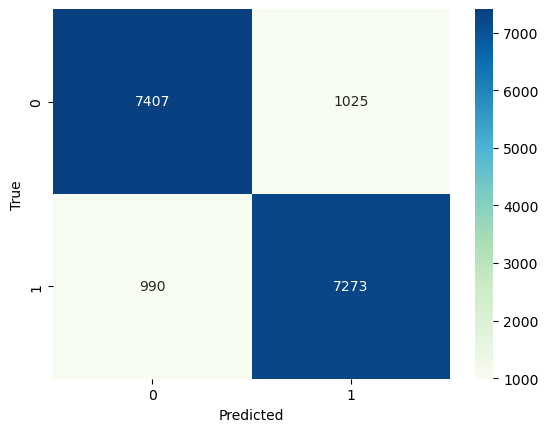

In [159]:
tabla = confusion_matrix(y_test, y_pred)
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [163]:
y_predict_train = modelo.predict(x_train_minmax)
mostrar_scores(y_train, y_predict_train)

Accuracy: 0.9543575920934412
Recall: 0.9804979253112033
Precision: 0.9309563675760859
f1 score: 0.9550851311069571


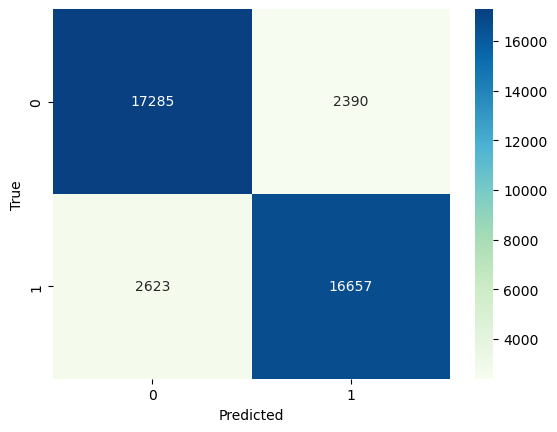

In [156]:
tabla = confusion_matrix(y_train, y_predict_train)
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Es normal que un random forest se overfitee un poco, por lo tanto, no nos deberia alarmar esta metrica. Es por esto que por ejemplo no utilicemos poda, para que nuestro arbol se extienda lo maximo posible. Ademas, el bootstraping y el bagging tambien ayudan a que el overfit no genere problemas ya que por cada arbol se toman distintos samples de datos.


In [37]:
from sklearn.model_selection import GridSearchCV

randomforest_cv = RandomForestClassifier(
    max_features='sqrt', oob_score=True, random_state=1, n_jobs=-1)


# param_grid = {
#     'bootstrap': [True],
#     'max_depth': [80, 90, 100, 110],
#     'min_samples_leaf': [1, 2, 3, 4, 5],
#     'n_estimators': [100, 200, 300, 1000]
# }

# grid_search = GridSearchCV(estimator = randomforest_cv, param_grid = param_grid,
#                           cv = 6, n_jobs = -1, verbose = 3)

# grid_search.fit(x_train, y_train)
# grid_search.best_params_

Con esto buscamos los mejores hiperparametros para nuestro random forest. Evitamos que los arboles se poden ya que esto no es beneficioso para los mismos.

## XGBoost

In [176]:
columns = [
    'hotel',
    'lead_time',
    'year',
    # 'month',
    'week_number',
    # 'day_of_month',
    # 'stays_in_weekend_nights',
    # 'stays_in_week_nights',
    # 'adults',
    # 'children',
    # 'babies',
    'meal_type',
    'country',
    'market_segment',
    # 'distribution_channel',
    'is_repeated_guest',
    'previous_cancellations',
    # 'previous_bookings_not_canceled',
    'booking_changes',
    'deposit_type',
    'agent_id',
    'days_in_waiting_list',
    'customer_type',
    'average_daily_rate',
    'required_car_parking_spaces',
    'total_of_special_requests',
    'is_canceled',
    # 'total_nights',
    'total_people'
]

dummy_columns = [
    'hotel',
    'deposit_type',
    'market_segment',
    'agent_id',
    'country',
    'customer_type',
    'meal_type',
    # 'distribution_channel',
    # 'month',
    # 'year'
]

Utilizamos este rango de columnas para ir filtrando con el objetivo de que nuestro modelo mejore.

In [177]:
agentes = df_a_utilizar[['agent_id']].value_counts().reset_index()

agentes.columns = ['agent_id', 'cantidad']
agentes_mayoritarios = agentes[agentes['cantidad'] > 50]
agentes_minoritarios = agentes[agentes['cantidad'] <= 50]

df_agentes_mayoritarios = df_a_utilizar[df_a_utilizar['agent_id'].isin(agentes_mayoritarios['agent_id'])]
df_agentes_minoritarios = df_a_utilizar[df_a_utilizar['agent_id'].isin(agentes_minoritarios['agent_id'])]
df_agentes_minoritarios.loc[df_a_utilizar['agent_id'].isin(agentes_minoritarios['agent_id']), 'agent_id'] = 'Otros'

df_agentes = pd.concat([df_agentes_mayoritarios, df_agentes_minoritarios])

paises = df_agentes[['country']].value_counts().reset_index()
paises.columns = ['country', 'cantidad']
paises_mayoritarios = paises[paises['cantidad'] > 800]
paises_minoritarios = paises[paises['cantidad'] <= 800]

df_paises_mayoritarios = df_agentes[df_agentes['country'].isin(paises_mayoritarios['country'])]
df_paises_minoritarios = df_agentes[df_agentes['country'].isin(paises_minoritarios['country'])]
df_paises_minoritarios.loc[df_agentes['country'].isin(paises_minoritarios['country']), 'country'] = 'Otros'

df_encode = pd.concat([df_paises_mayoritarios, df_paises_minoritarios])

filtrado = df_encode[columns]

df_con_dummies = pd.get_dummies(filtrado, columns=dummy_columns, drop_first=True)


df_con_dummies['cuarto_correcto'] = df_ensambles['reserved_room_type'] == df_ensambles['assigned_room_type']
df_con_dummies['cuarto_correcto'] = df_con_dummies['cuarto_correcto'].apply(
    lambda x: 1 if x == True else 0)

df_trabajo_x = df_con_dummies.drop(
    ['is_canceled'], axis='columns', inplace=False)
df_trabajo_y = df_con_dummies['is_canceled'].copy()

Realizamos el mismo filtrados que en el random forest ya uqe notamos uqe con los arboles de decision nos dieron muy buenos resultados.

In [178]:
target = 'is_canceled'
x_train, x_test, y_train, y_test = train_test_split(df_trabajo_x,
                                                    df_trabajo_y,
                                                    test_size=0.3,
                                                    random_state=11457,
                                                    stratify=df_con_dummies[target].values
                                                    )

In [184]:
import xgboost as xgb

# xgb_model = xgb.XGBClassifier(random_state=0, n_estimators=100)
# xgb_model.fit(x_train, y_train)
# y_pred=xgb_model.predict(x_test)

# data_dmatrix = xgb.DMatrix(data=x_train, label=y_train)

# #Entreno CV para probar el learning rate
# results=xgb.cv(dtrain=data_dmatrix,nfold=6,params={'learning_rate':0.04, 'max_depth': 50},num_boost_round=8,metrics='error')

# # mostrar_scores(y_test, y_pred)
# results

# Create a DMatrix for XGBoost
#dtrain = xgb.DMatrix(x_train, label=y_train)
#dtest = xgb.DMatrix(x_test, label=y_test)

dtrain_clf = xgb.DMatrix(x_train, y_train)
dtest_clf = xgb.DMatrix(x_test, y_test)

params = {
    "objective": "binary:logistic",
    "max_depth": 5,
    "eta": 0.07,
    "eval_metric": "error",
    "num_parallel_tree": 5,
    "sampling_method": "gradient_based",
}

num_round = 1000
model = xgb.train(params, dtrain_clf, num_round)

y_pred = model.predict(dtest_clf)
y_pred_binario = [1 if p > 0.5 else 0 for p in y_pred]
mostrar_scores(y_test, y_pred_binario)

Accuracy: 0.8740341419586702
Recall: 0.8882972286094639
Precision: 0.8615023474178404
f1 score: 0.8746946314723231


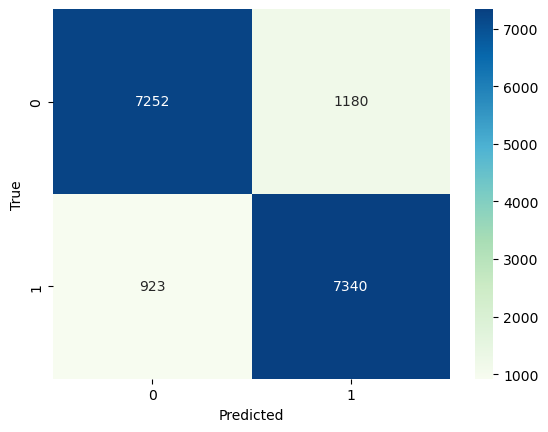

In [185]:
tabla = confusion_matrix(y_test, y_pred_binario)
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [199]:
import xgboost as xgb

min_max = preprocessing.MinMaxScaler()
x_train_minmax = min_max.fit_transform(x_train)
x_test_minmax = min_max.transform(x_test)


xgb_model = xgb.XGBClassifier(n_estimators=1000, eta=0.04,
                              max_depth=8, min_child_weight=1, colsample_bytree=0.8,  seed=27)
xgb_model.fit(x_train_minmax, y_train)
y_pred = xgb_model.predict(x_test_minmax)
mostrar_scores(y_test, y_pred)

Accuracy: 0.8786463012878107
Recall: 0.8925329783371657
Precision: 0.8663220956184658
f1 score: 0.8792322365283739


In [198]:
y_predict_train = modelo.predict(x_train_minmax)
mostrar_scores(y_train, y_predict_train)

Accuracy: 0.9543575920934412
Recall: 0.9804979253112033
Precision: 0.9309563675760859
f1 score: 0.9550851311069571


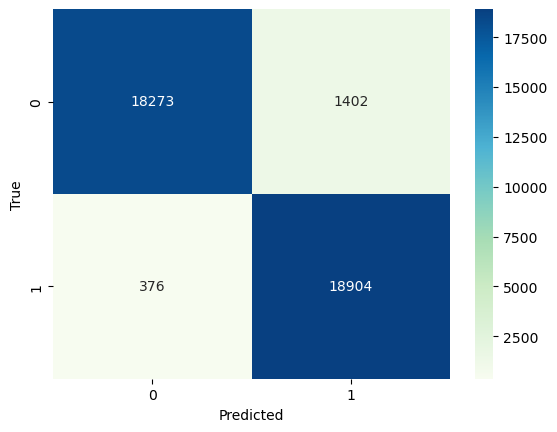

In [191]:
tabla = confusion_matrix(y_train, y_predict_train)
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Como se puede observar este modelo tambien esta levemente sobreentrenado.

## Stacking


In [180]:
df_a_utilizar = df_ensambles.copy()

In [200]:
agentes = df_a_utilizar[['agent_id']].value_counts().reset_index()

agentes.columns = ['agent_id', 'cantidad']
agentes_mayoritarios = agentes[agentes['cantidad'] > 50]
agentes_minoritarios = agentes[agentes['cantidad'] <= 50]

df_agentes_mayoritarios = df_a_utilizar[df_a_utilizar['agent_id'].isin(agentes_mayoritarios['agent_id'])]
df_agentes_minoritarios = df_a_utilizar[df_a_utilizar['agent_id'].isin(agentes_minoritarios['agent_id'])]
df_agentes_minoritarios.loc[df_a_utilizar['agent_id'].isin(agentes_minoritarios['agent_id']), 'agent_id'] = 'Otros'

df_agentes = pd.concat([df_agentes_mayoritarios, df_agentes_minoritarios])

paises = df_agentes[['country']].value_counts().reset_index()
paises.columns = ['country', 'cantidad']
paises_mayoritarios = paises[paises['cantidad'] > 800]
paises_minoritarios = paises[paises['cantidad'] <= 800]

df_paises_mayoritarios = df_agentes[df_agentes['country'].isin(paises_mayoritarios['country'])]
df_paises_minoritarios = df_agentes[df_agentes['country'].isin(paises_minoritarios['country'])]
df_paises_minoritarios.loc[df_agentes['country'].isin(paises_minoritarios['country']), 'country'] = 'Otros'

df_encode = pd.concat([df_paises_mayoritarios, df_paises_minoritarios])

filtrado = df_encode[columns]

df_con_dummies = pd.get_dummies(filtrado, columns=dummy_columns, drop_first=True)


df_con_dummies['cuarto_correcto'] = df_ensambles['reserved_room_type'] == df_ensambles['assigned_room_type']
df_con_dummies['cuarto_correcto'] = df_con_dummies['cuarto_correcto'].apply(
    lambda x: 1 if x == True else 0)

df_trabajo_x = df_con_dummies.drop(
    ['is_canceled'], axis='columns', inplace=False)
df_trabajo_y = df_con_dummies['is_canceled'].copy()

In [201]:
columns = [
    'hotel',
    'lead_time',
    'year',
    # 'month',
    'week_number',
    # 'day_of_month',
    # 'stays_in_weekend_nights',
    # 'stays_in_week_nights',
    # 'adults',
    # 'children',
    # 'babies',
    'meal_type',
    'country',
    'market_segment',
    # 'distribution_channel',
    'is_repeated_guest',
    'previous_cancellations',
    # 'previous_bookings_not_canceled',
    'booking_changes',
    'deposit_type',
    'agent_id',
    'days_in_waiting_list',
    'customer_type',
    'average_daily_rate',
    'required_car_parking_spaces',
    'total_of_special_requests',
    'is_canceled',
    # 'total_nights',
    'total_people'
]

filtrado = df_encode[columns]

dummy_columns = [
    'hotel',
    'deposit_type',
    'market_segment',
    'agent_id',
    'country',
    'customer_type',
    'meal_type',
    # 'distribution_channel',
    # 'month',
    # 'year'
]

df_con_dummies = pd.get_dummies(
    filtrado, columns=dummy_columns, drop_first=True)

df_con_dummies['cuarto_correcto'] = df_encode['reserved_room_type'] == df_encode['assigned_room_type']
df_con_dummies['cuarto_correcto'] = df_con_dummies['cuarto_correcto'].apply(lambda x: 1 if x == True else 0)


df_trabajo_x = df_con_dummies.drop(
    ['is_canceled'], axis='columns', inplace=False)
df_trabajo_y = df_con_dummies['is_canceled'].copy()


x_train, x_test, y_train, y_test = train_test_split(df_trabajo_x,
                                                    df_trabajo_y,
                                                    test_size=0.3,
                                                    random_state=11457,
                                                    stratify=df_con_dummies[target].values
                                                    )

In [202]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

min_max = preprocessing.MinMaxScaler()
x_train_minmax = min_max.fit_transform(x_train)
x_test_minmax = min_max.transform(x_test)

estimadores = [
  ("random forest", random_forest_mejorado),
  ("xg boost", xgb_model),
]

log_model = LogisticRegression(random_state=33, max_iter=1000, n_jobs=-1, penalty='l2', C=0.1)

stacking_model = StackingClassifier(estimators=estimadores,
                                    passthrough=True,
                                    final_estimator=log_model,
                                    cv='prefit',
                                    verbose=2, 
                                    
                                    n_jobs=-1)

stacking_model.fit(x_train_minmax, y_train)
y_pred = stacking_model.predict(x_test_minmax)
mostrar_scores(y_test, y_pred)

Accuracy: 0.879005690326445
Recall: 0.878494493525354
Precision: 0.8772205438066465
f1 score: 0.8778570564759947


In [203]:
y_predict_train = stacking_model.predict(x_train_minmax)
mostrar_scores(y_train, y_predict_train)

Accuracy: 0.9616480554485946
Recall: 0.9696576763485477
Precision: 0.9536319118547235
f1 score: 0.9615780269519597


## Voting

In [108]:
agentes = df_a_utilizar[['agent_id']].value_counts().reset_index()

agentes.columns = ['agent_id', 'cantidad']
agentes_mayoritarios = agentes[agentes['cantidad'] > 20]
agentes_minoritarios = agentes[agentes['cantidad'] <= 20]

df_agentes_mayoritarios = df_a_utilizar[df_a_utilizar['agent_id'].isin(agentes_mayoritarios['agent_id'])]
df_agentes_minoritarios = df_a_utilizar[df_a_utilizar['agent_id'].isin(agentes_minoritarios['agent_id'])]
df_agentes_minoritarios.loc[df_a_utilizar['agent_id'].isin(agentes_minoritarios['agent_id']), 'agent_id'] = 'Otros'

df_agentes = pd.concat([df_agentes_mayoritarios, df_agentes_minoritarios])

paises = df_agentes[['country']].value_counts().reset_index()
paises.columns = ['country', 'cantidad']
paises_mayoritarios = paises[paises['cantidad'] > 15]
paises_minoritarios = paises[paises['cantidad'] <= 15]

df_paises_mayoritarios = df_agentes[df_agentes['country'].isin(
    paises_mayoritarios['country'])]
df_paises_minoritarios = df_agentes[df_agentes['country'].isin(
    paises_minoritarios['country'])]
df_paises_minoritarios.loc[df_agentes['country'].isin(
    paises_minoritarios['country']), 'country'] = 'Otros'

df_encode = pd.concat([df_paises_mayoritarios, df_paises_minoritarios])

In [109]:
columns = [
    'hotel',
    'lead_time',
    'year',
    # 'month',
    'week_number',
    # 'day_of_month',
    # 'stays_in_weekend_nights',
    # 'stays_in_week_nights',
    # 'adults',
    # 'children',
    # 'babies',
    'meal_type',
    'country',
    'market_segment',
    # 'distribution_channel',
    'is_repeated_guest',
    'previous_cancellations',
    # 'previous_bookings_not_canceled',
    'booking_changes',
    'deposit_type',
    'agent_id',
    'days_in_waiting_list',
    'customer_type',
    'average_daily_rate',
    'required_car_parking_spaces',
    'total_of_special_requests',
    'is_canceled',
    # 'total_nights',
    'total_people'
]

filtrado = df_encode[columns]

dummy_columns = [
    'hotel',
    'deposit_type',
    'market_segment',
    'agent_id',
    'country',
    'customer_type',
    'meal_type',
    # 'distribution_channel',
    # 'month',
    # 'year'
]

df_con_dummies = pd.get_dummies(
    filtrado, columns=dummy_columns, drop_first=True)

df_con_dummies['cuarto_correcto'] = df_encode['reserved_room_type'] == df_encode['assigned_room_type']
df_con_dummies['cuarto_correcto'] = df_con_dummies['cuarto_correcto'].apply(lambda x: 1 if x == True else 0)



df_trabajo_x = df_con_dummies.drop(
    ['is_canceled'], axis='columns', inplace=False)
df_trabajo_y = df_con_dummies['is_canceled'].copy()


x_train, x_test, y_train, y_test = train_test_split(df_trabajo_x,
                                                    df_trabajo_y,
                                                    test_size=0.3,
                                                    random_state=11457,
                                                    stratify=df_con_dummies[target].values
                                                    )

In [110]:
from sklearn.ensemble import VotingClassifier


min_max = preprocessing.MinMaxScaler()
x_train_minmax = min_max.fit_transform(x_train)
x_test_minmax = min_max.transform(x_test)

estimadores = [
  ("random forest", random_forest_mejorado),
  # ("svm", svm_poly_5),
  ("xg boost", xgb_model)
]

voting_model = VotingClassifier(estimators=estimadores,
                                    verbose=2, 
                                    n_jobs=-1)

voting_model.fit(x_train, y_train)
y_pred = voting_model.predict(x_test)
mostrar_scores(y_test, y_pred)

[Voting] ............ (1 of 2) Processing random forest, total=   9.1s
[Voting] ................. (2 of 2) Processing xg boost, total= 4.2min
Accuracy: 0.873015873015873
Recall: 0.8581628948323853
Precision: 0.8820748849359373
f1 score: 0.8699546067967121


## Evaluación con el dataset de test

In [204]:
df_test = pd.read_csv('https://drive.usercontent.google.com/download?id=1ruDne6JVJTwK0TbDNQEUfUtoxA6gVTiy&export=download&authuser=0&confirm=t&uuid=2892328a-d7d8-47c7-98e1-3e69ef723100&at=APZUnTU5aCf9tHsTaF3PM7aD9Lym:1695760323667')

df_test.shape

(26535, 31)

### Imputacion

In [205]:
nuevas_columnas = {
    'arrival_date_year' : 'year',
    'arrival_date_month' : 'month',
    'arrival_date_week_number' : 'week_number',
    'arrival_date_day_of_month' : 'day_of_month',
    'meal' : 'meal_type',
    'agent' : 'agent_id',
    'adr' : 'average_daily_rate'
}
df_test.rename(columns = nuevas_columnas, inplace = True)

Imputacion children, company y adults

In [206]:
df_test['total_nights'] = df_test['stays_in_week_nights'] + df_test['stays_in_weekend_nights']
df_test['children'].fillna(0, inplace=True)
df_test['total_people'] = df_test['adults'] + df_test['children'] + df_test['babies']
df_test['meal_type'].replace(['SC', 'Undefined'], 'NoMeal', inplace=True)
df_test.drop(columns=['company'], inplace=True)

Imputación de agent id

In [207]:
for index, row in df_test.iterrows():
    if (pd.isna(row['agent_id'])) & (row['distribution_channel'] == 'Direct'):
        df_test.loc[index, 'agent_id'] = -1

for index, row in df_test.iterrows():
    if (not pd.isna(row['agent_id'])) or (row['distribution_channel'] == 'Direct'):
        continue
    if row['hotel'] == 'City Hotel':
        if row['country'] == 'PRT':
            df_test.loc[index, 'agent_id'] = 1.0
        else: 
            df_test.loc[index, 'agent_id'] = 9.0
    else:
        df_test.loc[index, 'agent_id'] = 240.0

Imputación de country

In [208]:
for index, row in df_test.iterrows():
    if pd.isna(row['country']) and row['deposit_type'] == 'Non Refund':
        df_test.loc[index, 'country'] = 'PRT'

for index, row in df_test.iterrows():
    if pd.isna(row['country']) and (row['market_segment'] == 'Corporate' or row['market_segment'] == 'Offline TA/TO' or row['market_segment'] == 'Direct'):
        df_test.loc[index, 'country'] = 'PRT'

In [209]:
mejor_modelo = stacking_model

In [210]:
df_encode = df_test.copy()

df_encode['agent_id'] = df_test['agent_id'].apply(lambda x: x if x in list(df_agentes_mayoritarios['agent_id']) else 'Otros')
df_encode['country'] = df_test['country'].apply(lambda x: x if x in list(df_paises_mayoritarios['country']) else 'Otros')

columns.remove('is_canceled')
df_filtrado = df_encode[columns]
columns.append('is_canceled')
df_test_con_dummies = pd.get_dummies(df_filtrado, columns=dummy_columns, drop_first=True).reset_index(drop=True)

df_test_con_dummies['cuarto_correcto'] = df_encode['reserved_room_type'] == df_encode['assigned_room_type']
df_test_con_dummies['cuarto_correcto'] = df_test_con_dummies['cuarto_correcto'].apply(lambda x: 1 if x == True else 0)

df_minmax = min_max.transform(df_test_con_dummies)

y_pred = mejor_modelo.predict(df_minmax)

df_prediccion = pd.DataFrame(y_pred, columns=['is_canceled'])
df_prediccion['id'] = df_test['id']
df_prediccion = df_prediccion[['id', 'is_canceled']]


df_prediccion.to_csv('prediccion.csv', index=False)